# **Izgradnja i Evaluacija Modela za Klasifikaciju Gustine Dojki**

Ovaj rad prikazuje postupak izrade modela za klasifikaciju gustine dojki koristeći unapred trenirani VGG16 model. Korišćen je MIAS Mammography dataset, koji sadrži mamografske snimke klasifikovane u četiri klase gustine: A, B, C i D. Proces obuhvata pripremu podataka, treniranje modela i njegovu evaluaciju, sa naglaskom na izračunavanje i interpretaciju matrice konfuzije kako bi se ocenile performanse modela.

Definišemo putanje za ulazni dataset i izlazni direktorijum gde ćemo smestiti procesirane podatke. Zatim kreiramo potrebne direktorijume za trening i test setove unutar izlaznog direktorijuma.

Definišemo klase gustine dojki (A, B, C, D) i kreiramo odgovarajuće direktorijume unutar trening i test setova.

Iteriramo kroz sve slike u dataset-u, ekstraktujemo broj iz imena fajla i raspodeljujemo slike u odgovarajuće klase koristeći modulo operaciju.
Modulo operacija je jednostavan način da ravnomerno raspodelimo slike u više klasa. U ovom slučaju, delimo slike u četiri klase (A, B, C, D) na osnovu ostatka pri deljenju broja slike sa 4. Ovaj pristup osigurava da svaka klasa dobije približno jednak broj slika, što je važno za balansiranost treninga modela.

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Pretpostavljamo da su slike u direktorijumu "all-mias"

dataset_dir = '/content/data'
output_dir = '/content/processed_data/'

# Kreiranje izlaznih direktorijuma za trening i test setove
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

classes = ['A', 'B', 'C', 'D']  # Klase gustine dojki
for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Sortiranje slika po klasama
file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        # Ekstrakcija broja iz imena fajla
        file_number = int(filename[3:6])

        # Raspodela slika po klasama koristeći modulo operaciju
        if file_number % 4 == 0:
            class_label = 'A'
        elif file_number % 4 == 1:
            class_label = 'B'
        elif file_number % 4 == 2:
            class_label = 'C'
        else:
            class_label = 'D'

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

# Podela na trening i test setove
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Kopiranje slika u odgovarajuće direktorijume
for file, label in zip(train_files, train_labels):
    dst = os.path.join(train_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

for file, label in zip(test_files, test_labels):
    dst = os.path.join(test_dir, label, os.path.basename(file))
    shutil.copyfile(file, dst)

print("Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.")

Slike su uspešno podeljene i kopirane u odgovarajuće direktorijume.


Definišemo ključne parametre kao što su dimenzije slika, veličina batch-a i broj klasa.
Navodimo putanje direktorijuma za dataset i procesirane podatke. Definišemo klase za gustinu dojki i kreiramo funkciju za konverziju PGM slika u RGB format, kako su slike u pgm formatu.
Zatim delimo dataset na trening i test skupove uz održavanje distribucije klasa.
Konvertujemo slike iz PGM u RGB format i čuvamo ih u odgovarajućim direktorijumima.

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.applications import VGG16
import datetime

# Parametri
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4  # Broj klasa gustine

# Putanje direktorijuma
dataset_dir = '/content/data'
output_dir = '/content/processed_data/'

# Kreiranje izlaznih direktorijuma za trening i test setove
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definisanje lista klasa
classes = ['A', 'B', 'C', 'D']

# Funkcija za konverziju slike iz PGM u RGB format
def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

# Sakupljanje putanja i labela
file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

# Podela na trening i test skupove
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Konverzija i čuvanje slika u odgovarajućim direktorijumima
def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)


Definisanje ImageDataGenerator-a za Trening i Test Skupove

Primenujemo augmentaciju podataka na trening skup kako bismo poboljšali generalizaciju modela i reskaliramo slike za trening i test skupove.

Kreiramo generatore podataka za trening i validacioni (test) skup.

Koristimo unapred trenirani VGG16 model za ekstrakciju karakteristika. VGG16 model je treniran na ImageNet dataset-u i uključuje samo konvolucione slojeve (bez gornjih slojeva).

Zamrzavamo početne slojeve modela i dodajemo nove slojeve za klasifikaciju.
Kompilujemo model koristeći Adam optimizator i kategorijalni unakrsni entropijski gubitak i definišemo callback-ove za rano zaustavljanje, čuvanje najboljeg modela i TensorBoard logovanje.

In [4]:
from tensorflow.keras import regularizers  # Dodatni import za regularizers

# Parametri
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4  # Broj klasa gustine

# Putanje direktorijuma
dataset_dir = '/content/data'
output_dir = '/content/processed_data/'

# Kreiranje izlaznih direktorijuma za trening i test setove
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definisanje lista klasa
classes = ['A', 'B', 'C', 'D']

# Funkcija za konverziju slike iz PGM u RGB format
def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

# Sakupljanje putanja i labela
file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

# Podela na trening i test skupove
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Konverzija i čuvanje slika u odgovarajućim direktorijumima
def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

# Definisanje ImageDataGenerator-a za augmentaciju podataka
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Kreiranje generatorskih objekata
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Definisanje modela sa unapred treniranim VGG16 modelom
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Odmrzavanje poslednjih nekoliko slojeva VGG16 modela
fine_tune_at = 15
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Kompilacija modela
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Definisanje callback-ova
log_dir = "/content/drive/My Drive/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/breast_density_model.keras', save_best_only=True)

callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Treniramo model koristeći generatore podataka i definišemo broj epoha u ovom slučaju 50 epoha.

Prikazujemo grafikone gubitka i tačnosti tokom treninga.




Dodali smo dodatni Dense sloj sa 512 jedinica, zatim još jedan Dense sloj sa 256 jedinica nakon toga. Odmrzli smo sve slojeve u osnovnom modelu VGG16 i povećali stopu učenja optimizer-a Adam. T

In [5]:
# Parametri
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4  # Broj klasa gustine

# Putanje direktorijuma
dataset_dir = '/content/data'
output_dir = '/content/processed_data/'

# Kreiranje izlaznih direktorijuma za trening i test setove
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definisanje lista klasa
classes = ['A', 'B', 'C', 'D']

# Funkcija za konverziju slike iz PGM u RGB format
def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

# Sakupljanje putanja i labela
file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

# Podela na trening i test skupove
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Konverzija i čuvanje slika u odgovarajućim direktorijumima
def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

# Definisanje ImageDataGenerator-a za augmentaciju podataka
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Kreiranje generatorskih objekata
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Definisanje modela sa unapred treniranim VGG16 modelom
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Odmrzavanje slojeva baznog modela
base_model.trainable = True

# Kompilacija modela
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Definisanje callback-ova
log_dir = "/content/drive/My Drive/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/breast_density_model.keras', save_best_only=True)

callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


Potencijalno rešenje sa ResNet50

In [6]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parametri
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4  # Broj klasa gustine

# Putanje direktorijuma
dataset_dir = '/content/data'
output_dir = '/content/processed_data/'

# Kreiranje izlaznih direktorijuma za trening i test setove
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definisanje lista klasa
classes = ['A', 'B', 'C', 'D']

# Funkcija za konverziju slike iz PGM u RGB format
def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

# Sakupljanje putanja i labela
file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

# Podela na trening i test skupove
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Konverzija i čuvanje slika u odgovarajućim direktorijumima
def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

# Definisanje ImageDataGenerator-a za augmentaciju podataka
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Kreiranje generatorskih objekata
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

print("Broj uzoraka u trening skupu:", train_generator.samples)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Kreiranje modela sa ResNet50 arhitekturom
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Zamrzavanje slojeva baznog modela
base_model.trainable = False

# Kompilacija modela
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Definisanje callback-ova
log_dir = "/content/drive/My Drive/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/breast_density_model.keras', save_best_only=True)

callbacks = [early_stopping, model_checkpoint, tensorboard_callback]

Found 257 images belonging to 4 classes.
Broj uzoraka u trening skupu: 257
Found 65 images belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 41s 41s/step - accuracy: 0.3750 - loss: 1.8271 - val_accuracy: 0.3077 - val_loss: 1.5647
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 33s 33s/step - accuracy: 0.2500 - loss: 1.7028 - val_accuracy: 0.2769 - val_loss: 1.5744
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step - accuracy: 0.2500 - loss: 1.9103 - val_accuracy: 0.2769 - val_loss: 1.5267
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 35s 35s/step - accuracy: 0.4375 - loss: 1.7743 - val_accuracy: 0.2615 - val_loss: 1.4820
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 25s 25s/step - accuracy: 0.1250 - loss: 2.1184 - val_accuracy: 0.3385 - val_loss: 1.4393
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 26s 26s/step - accuracy: 0.4375 - loss: 1.4523 - val_accuracy: 0.3231 - val_loss: 1.4086
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 37s 37s/step - accuracy: 0.3750 - loss: 2.1125 - val_accuracy: 0.2923 - val_loss: 1.3972
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step - accuracy: 0.0625 - loss: 2.0980 - val_accuracy: 0.3231 - val_loss: 1.4021
Epoch 9/20


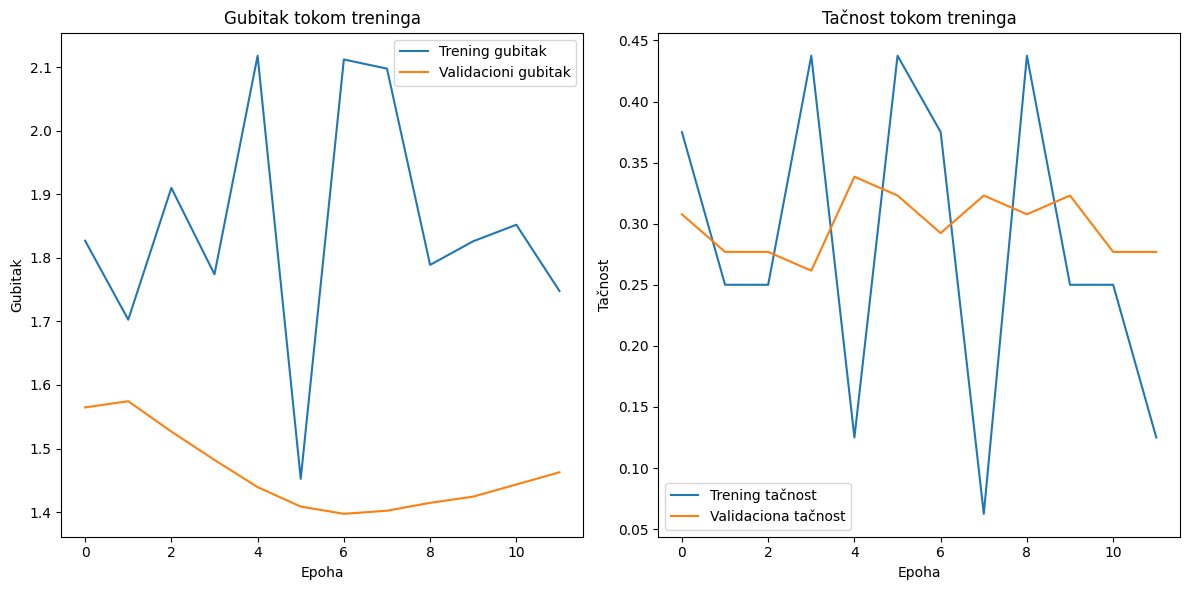

In [7]:
# Treniranje modela
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // batch_size,
    epochs=20,
    callbacks=callbacks
)

# Funkcija za prikaz metrika tokom treninga
def plot_training(history):
    plt.figure(figsize=(12, 6))

    # Prikaz gubitka
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    # Prikaz tačnosti
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Prikaz rezultata treninga
plot_training(history)

Found 65 images belonging to 4 classes.
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step
Matrica konfuzije:
[[1 3 8 4]
 [3 5 4 4]
 [0 5 6 6]
 [0 5 4 7]]


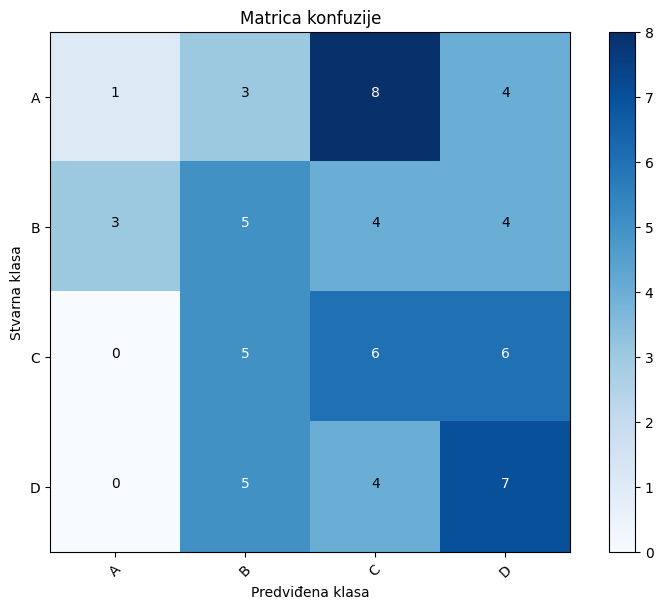

              precision    recall  f1-score   support

           A       0.25      0.06      0.10        16
           B       0.28      0.31      0.29        16
           C       0.27      0.35      0.31        17
           D       0.33      0.44      0.38        16

    accuracy                           0.29        65
   macro avg       0.28      0.29      0.27        65
weighted avg       0.28      0.29      0.27        65



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools  # Import za prikaz matrice konfuzije

# Predikcija na testnom skupu
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False  # Važno je da testni generator nije promešan kako bi se sačuvali redosledi
)

test_steps = len(test_generator)
predictions = model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)

# Izračunavanje matrice konfuzije
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print('Matrica konfuzije:')
print(conf_matrix)

# Prikaži matricu konfuzije
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Matrica konfuzije')
plt.colorbar()

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Stvarna klasa')
plt.xlabel('Predviđena klasa')
plt.show()

# Prikaz metrika
print(classification_report(true_classes, predicted_classes, target_names=class_labels))


Ponovni pokušaj

In [9]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# Parametri
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4  # Broj klasa gustine

# Putanje direktorijuma
dataset_dir = '/content/data'
output_dir = '/content/processed_data/'

# Kreiranje izlaznih direktorijuma za trening i test setove
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definisanje lista klasa
classes = ['A', 'B', 'C', 'D']

# Funkcija za konverziju slike iz PGM u RGB format
def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

# Sakupljanje putanja i labela
file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

# Podela na trening i test skupove
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Konverzija i čuvanje slika u odgovarajućim direktorijumima
def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

# Definisanje ImageDataGenerator-a za augmentaciju podataka
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Kreiranje generatorskih objekata
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Definisanje modela sa unapred treniranim VGG16 modelom
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Zamrzavanje slojeva baznog modela
base_model.trainable = False

# Kompilacija modela
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Definisanje callback-ova
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model.keras', save_best_only=True)
]


Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 60s 60s/step - accuracy: 0.1250 - loss: 1.6944 - val_accuracy: 0.2462 - val_loss: 1.4366
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.3125 - loss: 1.6625 - val_accuracy: 0.2923 - val_loss: 1.4084
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.2500 - loss: 1.5703 - val_accuracy: 0.2615 - val_loss: 1.3712
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - accuracy: 0.5000 - loss: 1.2152 - val_accuracy: 0.2615 - val_loss: 1.3386
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 43s 43s/step - accuracy: 1.0000 - loss: 0.7215 - val_accuracy: 0.2462 - val_loss: 1.3536
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - accuracy: 0.1250 - loss: 1.8762 - val_accuracy: 0.2615 - val_loss: 1.3468
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - accuracy: 0.3125 - loss: 1.7485 - val_accuracy: 0.4923 - val_loss: 1.3319
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - accuracy: 0.0625 - loss: 1.9345 - val_accuracy: 0.2615 - val_loss: 1.3490
Epoch 9/50


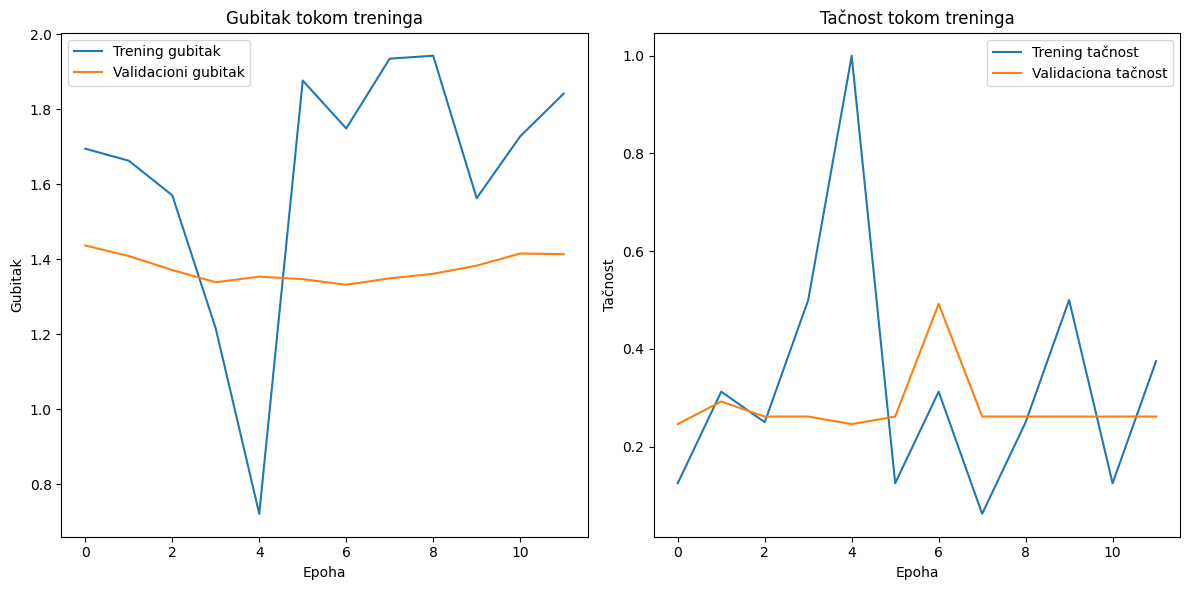

In [10]:
# Treniranje modela
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // batch_size,
    epochs=50,
    callbacks=callbacks
)

# Funkcija za prikaz metrika tokom treninga
def plot_training(history):
    plt.figure(figsize=(12, 6))

    # Prikaz gubitka
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    # Prikaz tačnosti
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Prikaz rezultata treninga
plot_training(history)


In [11]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

# Parametri
img_height, img_width = 224, 224
batch_size = 16
num_classes = 4  # Broj klasa gustine

# Putanje direktorijuma
dataset_dir = '/content/data'
output_dir = '/content/processed_data/'

# Kreiranje izlaznih direktorijuma za trening i test setove
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Definisanje lista klasa
classes = ['A', 'B', 'C', 'D']

# Funkcija za konverziju slike iz PGM u RGB format
def pgm_to_rgb(pgm_image_path):
    pgm_image = cv2.imread(pgm_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.cvtColor(pgm_image, cv2.COLOR_GRAY2RGB)
    return rgb_image

# Sakupljanje putanja i labela
file_paths = []
file_labels = []

for filename in os.listdir(dataset_dir):
    if filename.endswith('.pgm') and filename.startswith('mdb'):
        file_number = int(filename[3:6])
        class_label = classes[file_number % 4]

        file_paths.append(os.path.join(dataset_dir, filename))
        file_labels.append(class_label)

# Podela na trening i test skupove
train_files, test_files, train_labels, test_labels = train_test_split(file_paths, file_labels, test_size=0.2, stratify=file_labels, random_state=42)

# Konverzija i čuvanje slika u odgovarajućim direktorijumima
def convert_and_save_images(files, labels, output_directory):
    for file, label in zip(files, labels):
        dst = os.path.join(output_directory, label, os.path.basename(file).replace('.pgm', '.jpg'))
        rgb_image = pgm_to_rgb(file)
        cv2.imwrite(dst, rgb_image)

convert_and_save_images(train_files, train_labels, train_dir)
convert_and_save_images(test_files, test_labels, test_dir)

# Definisanje ImageDataGenerator-a za augmentaciju podataka
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Kreiranje generatorskih objekata
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Kreiranje modela
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Kompilacija modela
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Definisanje callback-ova
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/My Drive/breast_density_model.keras', save_best_only=True)
]

Found 257 images belonging to 4 classes.
Found 65 images belonging to 4 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step - accuracy: 0.1250 - loss: 1.3831 - val_accuracy: 0.3385 - val_loss: 1.3834
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3125 - loss: 1.3955 - val_accuracy: 0.1692 - val_loss: 1.3897
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.4375 - loss: 1.3605 - val_accuracy: 0.1692 - val_loss: 1.4007
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.1875 - loss: 1.4021 - val_accuracy: 0.2462 - val_loss: 1.4117
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.3125 - loss: 1.4218 - val_accuracy: 0.2462 - val_loss: 1.4178
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.0000e+00 - loss: 1.5223 - val_accuracy: 0.2308 - val_loss: 1.4196


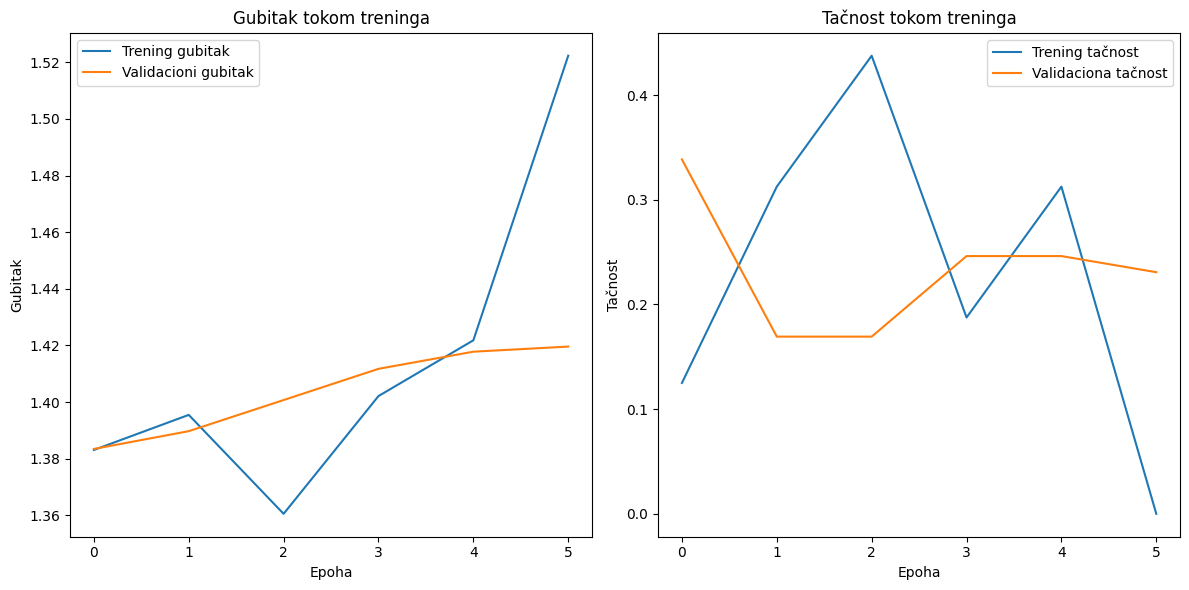

In [12]:
# Treniranje modela
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator) // batch_size,
    validation_data=validation_generator,
    validation_steps=len(validation_generator) // batch_size,
    epochs=20,
    callbacks=callbacks
)

# Funkcija za prikaz metrika tokom treninga
def plot_training(history):
    plt.figure(figsize=(12, 6))

    # Prikaz gubitka
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Trening gubitak')
    plt.plot(history.history['val_loss'], label='Validacioni gubitak')
    plt.xlabel('Epoha')
    plt.ylabel('Gubitak')
    plt.title('Gubitak tokom treninga')
    plt.legend()

    # Prikaz tačnosti
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Trening tačnost')
    plt.plot(history.history['val_accuracy'], label='Validaciona tačnost')
    plt.xlabel('Epoha')
    plt.ylabel('Tačnost')
    plt.title('Tačnost tokom treninga')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Prikaz rezultata treninga
plot_training(history)